<h1><center>Analysis and prediction of deaths in Switzerland</center></h1>
<h2><center>Project work, time series analysis FHNW Brugg</center></h2>
<h3><center>Claudio Schmidli</center></h3>
<h4><center>30.06.2023</center></h4>

In this timeseries project, I aim to analyze the weekly deaths in Switzerland and forecast future trends. Understanding the patterns and trends in mortality rates can provide valuable insights for various purposes, such as public health planning, resource allocation, and policy decision-making. By leveraging the power of data analysis and predictive modeling, we can gain a better understanding of the underlying factors driving mortality and make informed projections.

**Data source**<br>
The data for this project is sourced from the Swiss Federal Statistical Office. The dataset contains information on weekly numbers of deaths, expected deaths, and excess mortality by age groups (0-64, 65+), covering the period from 2010 to 2023.


<table>
<thead>
  <tr>
  </tr>
</thead>
<tbody>
<tr>
    <td>Label</td>
    <td>Weekly Deaths, 2010-2023</td>
  </tr>
<tr>
    <td>Publisher</td>
    <td>Federal Statistical Office</td>
  </tr>
  <tr>
  <tr>
    <td>Copyright</td>
    <td>Federal Statistical Office</td>
  </tr>
  <tr>
    <td>Terms of Use</td>
    <td>OPEN-BY-ASK</td>
  </tr>
  <tr>
    <td>Topic</td>
    <td>Health</td>
  </tr>
  <tr>
    <td>Federal Statistical Office Number</td>
    <td>ts-d-14.03.04.03-wr</td>
  </tr>
  <tr>
    <td>Data Collection, Statistics</td>
    <td><a href="https://www.bfs.admin.ch/bfs/en/home/statistics/health/surveys/ecod.html">Statistics of Causes of Death and Stillbirths</a></td>
  </tr>
  <tr>
    <td>Related Documents</td>
    <td><a href="https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/gnpdetail.2023-0076.html" target="_blank" rel="noopener noreferrer">Mortality Monitoring (MOMO): Weekly Update</a></td>
  </tr>
  <tr>
    <td>Source</td>
    <td><a href="https://www.bfs.admin.ch/bfsstatic/dam/assets/25985341/master" target="_blank" rel="noopener noreferrer">CSV File</a></td>
  </tr>
</tbody>
</table>


**Data Visualization and Exploratory Data Analysis:**<br>
Before delving into the modeling process, I begin by visualizing the weekly death data to gain a preliminary understanding. I explore the data for any apparent seasonal patterns and assess its stationarity.

**Utilizing ARIMA for Model Fitting and Prediction:**<br>
Then I employ the ARIMA (AutoRegressive Integrated Moving Average) modeling technique to capture the dynamics of the weekly death data in Switzerland. ARIMA is a powerful tool for timeseries analysis, as it combines both autoregressive (AR) and moving average (MA) components with differencing to handle non-stationarity. After fitting an appropriate ARIMA model to the historical data, future values can be predicted.
In this project I will create two different ARIMA models. 

1. In the first approach, I manually select the order parameters for the ARIMA model based on my observations from the exploratory data analysis. Additionally, I perform a data transformation to remove the seasonal patterns and make the data stationary. This transformation ensures that the model captures the underlying patterns more effectively. I evaluate the model's performance by analyzing the residuals, density plot, autocorrelation function (ACF), partial autocorrelation function (PACF) and comparing the model to the actual (true) values. The later is done using different metrics as well as with visualizations.
2. In the second approach, I utilize a Python package to automatically fit an ARIMA model to the original, untransformed data. To handle the non-stationarity of the data, the differencing order parameter (I) of the ARIMA model is set to a value > 0. This allows the model to account for the trend and seasonality in the data itself (no pre-processing needed). The quality of the model is assessed in the same way as in approach 1.

**Conclusion**<br>
Finally, I compare the manually created model with the model generated by auto ARIMA. I discuss the outcome of both approaches and the final outcome of the project.

**Literature on this topic:**<br>
https://www.hanser-elibrary.com/doi/book/10.3139/9783446468146


# 1. Load all needed Python libraries

In [7]:
import warnings
import json
import pprint
import requests     
import json         
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import sys
from statsmodels.tsa.stattools import adfuller
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from project.modules.timeseries import lineplot_multi_category_ax
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from datetime import date
import matplotlib.transforms as transforms
import statistics
from sklearn.metrics import mean_absolute_error,  mean_squared_error
import pmdarima as pm

# 2. Load Data
First, I download the latest data directly from [Swiss Opendata](https://opendata.swiss/dataset/wochentliche-todesfalle-2010-2023) using the following code. 

In [8]:
# Specify the package of interest:
package = 'wochentliche-todesfalle-2010-20231' #(remove the 1 at the end in case the link is not working)

# Set the base url for the package information. This is always the same.
base_url = 'https://opendata.swiss/api/3/action/package_show?id='

# Construct the url for the package of interest
package_information_url = base_url + package

# Make the HTTP request
package_information = requests.get(package_information_url)

# Use the json module to load CKAN's response into a dictionary
package_dict = json.loads(package_information.content)

# Check the contents of the response.
assert package_dict['success'] is True  # again make sure if response is OK
package_dict = package_dict['result']   # we only need the 'result' part from the dictionary
pprint.pprint(package_dict)             # pretty print the package information to screen

#Get the correct version of the dataset 
for i in range(0, len(package_dict['resources'])):
    if (package_dict['resources'][i]['display_name']['en'] == 'Weekly number of deaths, 2010-2023' and
        package_dict['resources'][i]['format'] == 'CSV'
        ):
        index_for_english_csv = i

# Get the url for the data from the dictionary
data_url = package_dict['resources'][index_for_english_csv]['url'] 
print('Data url:     ' + data_url)

# Print the data format
data_format = package_dict['resources'][index_for_english_csv]['format'] 
print('Data format:  ' + data_format)

# If data is hosted at GitHub, always download the raw data
if data_url.startswith('https://github.com/'):
    data_url = data_url.replace('https://github.com/', 'https://raw.githubusercontent.com/')
    data_url = data_url.replace('tree/', '')
print('Data url:     ' + data_url)

# List of formats we work with in this excercise
csv = ['comma-separated-values', 'CSV', 'csv']
tsv = ['tab-separated-values', 'TSV', 'tsv']
xls = ['XLS']

# Download the data to a Pandas DataFrame. Use seperate function calls, depending on the format of the dataset.
if any(s in data_format for s in csv):     # pd.read_csv()
    df = pd.read_csv(data_url, encoding = "ISO-8859-1", delimiter=';')
elif any(s in data_format for s in tsv):   # pd.read_csv() and specify the delimiter
    df = pd.read_csv(data_url, sep='\t')
elif any(s in data_format for s in xls):   # pd.read_excel()
    df = pd.read_excel(data_url)
else:
    print('Sorry, the data format is not supported for this exercise')
df.to_pickle("data.pkl")
# Print the first rows to the screen to inspect the dataset 
print('Data preview:')   
df.head(5)

{'accrual_periodicity': 'http://publications.europa.eu/resource/authority/frequency/WEEKLY',
 'author': None,
 'author_email': None,
 'contact_points': [{'email': 'auskunftsdienst@bfs.admin.ch',
                     'name': 'info@bfs.admin.ch'}],
 'creator_user_id': 'af084126-f711-4016-a585-70354e997796',
 'description': {'de': 'Dieser Dataset präsentiert die wöchentlichen Zahlen '
                       'der Todesfälle, der erwarteten Todesfälle und der '
                       'Übersterblichkeit nach Alter (0-64, 65+), 2010-2023.',
                 'en': 'This dataset presents the weekly figures for the '
                       'number of deaths, expected number of deaths and number '
                       'of excess deaths by age (0-64, 65+), from 2010 to '
                       '2023.',
                 'fr': 'Ce dataset présente les chiffres hebdomadaires du '
                       'nombre de décès, de décès attendus et de la '
                       "surmortalité selon l'âge (

,Year,Week,Ending,Age,NoDeaths_EP,Expected,LowerB,UpperB,Diff
0,2010,1.0,10.01.2010,0-64,193,195.0,159.0,231.0,.
1,2010,2.0,17.01.2010,0-64,198,195.0,159.0,231.0,.
2,2010,3.0,24.01.2010,0-64,191,194.0,158.0,230.0,.
3,2010,4.0,31.01.2010,0-64,207,194.0,158.0,229.0,.
4,2010,5.0,07.02.2010,0-64,175,193.0,157.0,229.0,.


# 3. Data Cleaning
In the following data processing steps, I perform whitespace stripping, eliminate unnecessary columns, and convert the data to suitable data types.

In [3]:
# Drop incomplete data
df = df[(~df['Year'].isna()) & (~df['Week'].isna()) & (~df['Age'].isna()) & (df['NoDeaths_EP']!='           .')]
# Select only relevant columns
df = df[['Year', 'Week', 'Ending', 	'Age', 'NoDeaths_EP']]
# Convert week to data type int
df['Week'] = df['Week'].astype(int)
# Set the date as index
df.index = df.apply(lambda x: date.fromisocalendar(int(x['Year']), int(x['Week']), 1), axis=1)
# Convert the number of deaths to data type float
df['NoDeaths_EP'] = df['NoDeaths_EP'].astype(float)
# Create a year_week column, which is later used by a custom build plotting function
df['year_week'] = df['Year'].astype(str) + df['Week'].astype(str).str.zfill(2)
# Strip white spaces from the category column 'age'
df['Age']=df['Age'].str.strip()
# Preview the data
df.head()

,Year,Week,Ending,Age,NoDeaths_EP,year_week
2010-01-04,2010,1,10.01.2010,0-64,193.0,201001
2010-01-11,2010,2,17.01.2010,0-64,198.0,201002
2010-01-18,2010,3,24.01.2010,0-64,191.0,201003
2010-01-25,2010,4,31.01.2010,0-64,207.0,201004
2010-02-01,2010,5,07.02.2010,0-64,175.0,201005


# 4. Visualize the data
In this step, I proceed to visualize the data in order to gain a deeper insight into its patterns and characteristics. For calculating the auto correlation I build an own custom function to calculate the values:

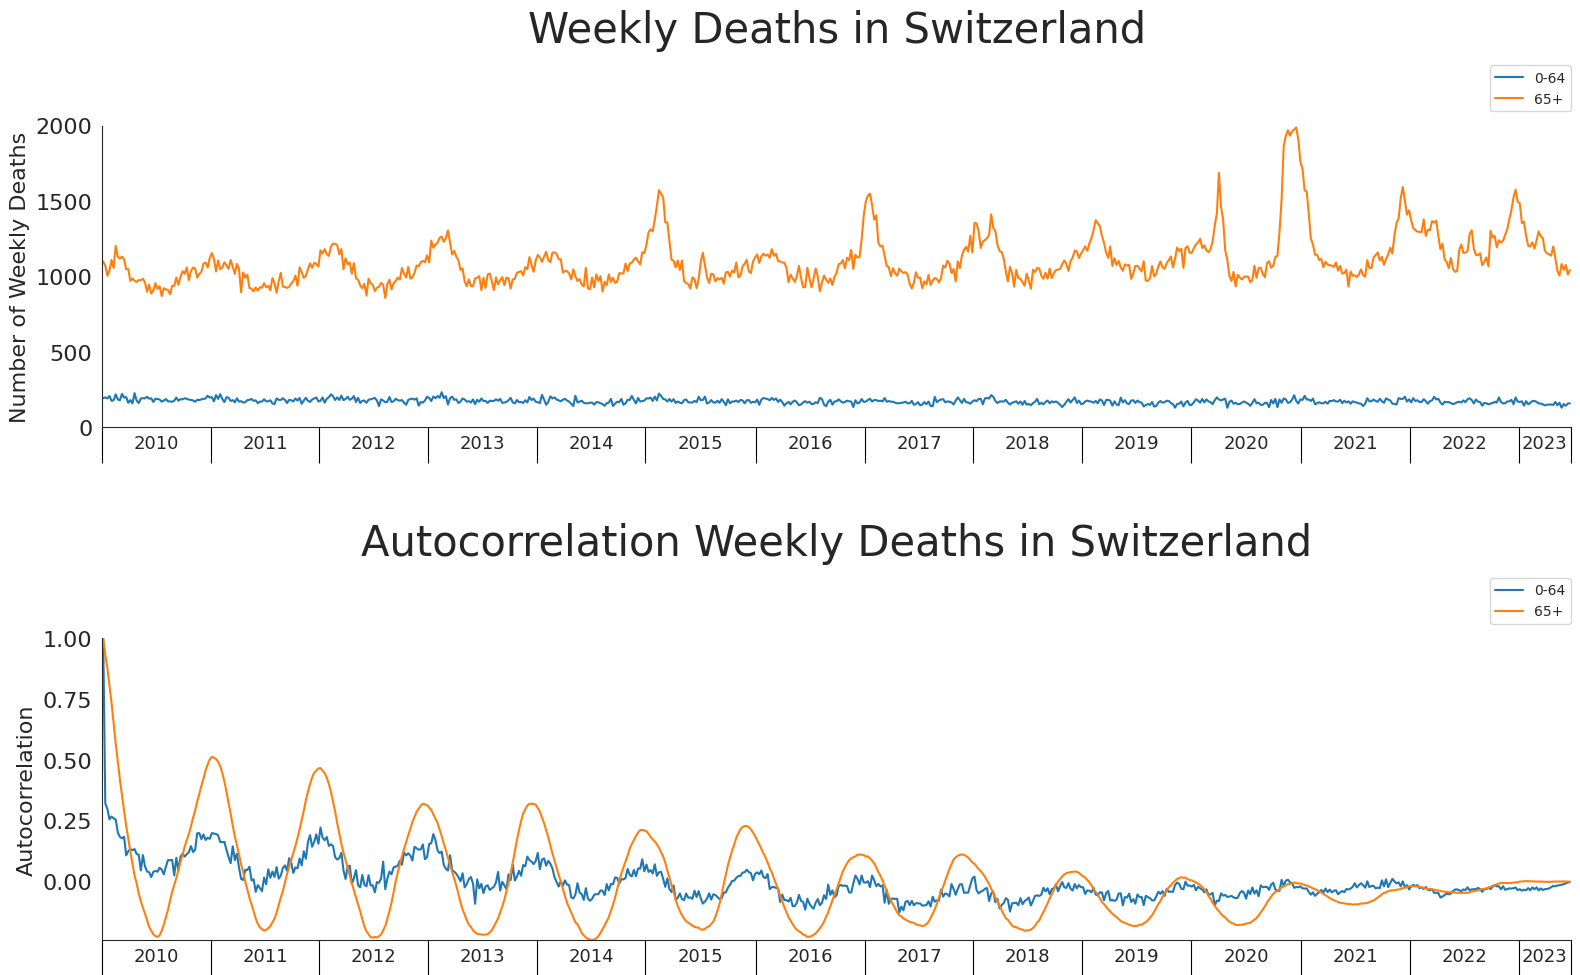

In [6]:
def calculate_auto_correlation(data:pd.Series, lag_range:range) ->  list: 
    """Calculate autocorrelation of a given Pandas Series on all lags of a given range.

    Args:
        data (pd.Series): Data of which the autocorrelation is calculated
        lag_range (range): Range defining all lags to be calculated

    Returns:
        list: List of autocorrelation factors.
    """

    # Allocate list to return all results
    acorr = len(lag_range) * [0]

    # Mean
    mean = sum(data) / len(data) 

    # Variance
    var = sum([(x - mean)**2 for x in data]) / len(data) 

    # Normalize data
    ndata = [x - mean for x in data]

    # Iterate over lag components 
    for lag in lag_range:
        c = 1 # Self correlation
        
        if (lag > 0):
            tmp = [ndata[lag:][i] * ndata[:-lag][i] for i in range(len(data) - lag)]
            c = sum(tmp) / len(data) / var
            
        acorr[lag] = c
    return acorr

def add_autocorrelation(data:pd.DataFrame, column:str, hue:str) -> pd.DataFrame:
    """Add autocorrelation factors to data (beginning on day 0).

    Args:
        data (pd.DataFrame): Data frame containing all data
        column (str): String of column name containing the data of which the autocorrelation is calculated.
        lag_range (range, optional): Range defining the range of lags.
        hue (str, optional): String of column name containing categories of which the autocorrelation is calculated seperately.

    Returns:
        pd.DataFrame: Input data frame with added autocorrelation column.
    """
    categories = data[hue].unique()
    for category in categories:
        filtered_data = data.loc[data[hue]==category, column]
        lag_range = range(len(filtered_data))
        data.loc[data[hue]==category, "auto_corr"] = calculate_auto_correlation(data=filtered_data, lag_range=lag_range)
    return data

df = add_autocorrelation(data = df, column="NoDeaths_EP", hue="Age")

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0] = lineplot_multi_category_ax(ax= ax[0], data = df,
x_values = 'year_week',
y_values = 'NoDeaths_EP',
title = 'Weekly Deaths in Switzerland',
hue='Age',
x_axis_label='',
y_axis_label='Number of Weekly Deaths')
ax[0].set_ylim(0, 2000)

ax[1] = lineplot_multi_category_ax(ax= ax[1],  data =  df,
                                    x_values = 'year_week',
                                    y_values = 'auto_corr',
                                    title = 'Autocorrelation Weekly Deaths in Switzerland',
                                    hue='Age',
                                    x_axis_label='',
                                    y_axis_label='Autocorrelation')
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()
df.drop('auto_corr', inplace=True, axis=1)

The dataset can be divided into two categories: 
- "Number of Deaths 0-64"
- "Number of Deaths 65+"

Upon observation, a clear seasonality pattern is evident for both categories. Each winter, a peak in the number of deaths can be observed, attributed to the seasonal flu. The seasonal patterns are also visible in the autocorrelation plot. Additionally, a notable increase in deaths between 2020 and 2022 is noticeable, which can be attributed to the impact of the COVID-19 pandemic.

# 5. Test/Train Split
Next, I divide the dataset into a test and train set. The train data is exclusively used for subsequent data analysis steps, while the test data is reserved for comparison purposes at the conclusion of the analysis. Moreover, the data corresponding to the '0-64' and '65+' age categories is stored in separate variables, facilitating subsequent steps and enhancing clarity in the process.

In [5]:
# Test/train split
split_year = 2019
df_test = df.loc[df['Year'].astype(int)>split_year].copy()
df_train = df.loc[df['Year'].astype(int)<=split_year].copy()
del df

# Age category split, test set
df_65_plus_test = df_test.loc[df_test['Age']=='65+'].copy()
df_0_64_test = df_test.loc[df_test['Age']=='0-64'].copy()
del df_test

# Age category split, train set
df_65_plus_train = df_train.loc[df_train['Age']=='65+'].copy()
df_0_64_train = df_train.loc[df_train['Age']=='0-64'].copy()
del df_train

# 6. Assess Stationarity
In the next step, I will assess the stationarity of the time series. To do so, I will employ the Augmented Dickey-Fuller test (ADF test).

For evaluating the test results, the following hypotheses are stated:

- **Null Hypothesis (H<sub>0</sub> ):** &emsp;&emsp;&emsp;&emsp;&emsp; The time series possesses a unit root and is non-stationary. H<sub>0</sub> cannot be rejected
- **Alternative Hypothesis (H<sub>1</sub> ):** &emsp;&nbsp;&nbsp; The time series does not have unit roots and is stationary. H<sub>0</sub>  is rejected.

For the final assesement, I calculate the p-value. If it is smaller than a significance level &alpha; = 0.05 the time series is considered to be stationary.<br> 
Conversely, if p > &alpha;, I I cannot reject H<sub>0</sub>, indicating that the time series is non-stationary.

In [6]:
# Test stationarity for the age category 65+
df_stationarityTest = adfuller(df_65_plus_train['NoDeaths_EP'], autolag='AIC')
print(f"p-value 65+:\t  {df_stationarityTest[1]}")
del df_stationarityTest

# Test stationarity for the age category 
df_stationarityTest = adfuller(df_0_64_train['NoDeaths_EP'], autolag='AIC')
print(f"p-value 0-64:\t  {df_stationarityTest[1]}")
del df_stationarityTest

p-value 65+:	  5.339649854523883e-06
p-value 0-64:	  3.534056154217938e-05


**Result:** The p-value is less than 0.05, indicating that the time series is stationary.

**Conclusion:** In addition to the assumptions of normality, most time series analysis models require stationarity. This condition is satisfied here.


## 7. Data transformation

Even though the time series is already stationary, I can still derive benefits from applying data transformations such as logarithmization and differencing. These transformations offer several advantages, including improved linearity, stabilized variance, smoother trends, model simplicity, and enhanced robustness to future changes. By employing these transformations, my objective is to enhance the performance and interpretability of the models, which may lead to superior overall results.

I will proceed with the following two methods:

**Logarithm Transformation:** &emsp;&emsp;&emsp;&emsp;&emsp;I will apply the logarithm transformation to the data.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;This transformation aims to establish a more linear relationship between variables and facilitate the interpretation of the results.

**Differencing to Remove Seasonality:** &nbsp;&nbsp;I will perform differencing to eliminate any remaining seasonal patterns in the data.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Differencing involves calculating the differences between consecutive observations.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;In seasonal differencing (which I will apply here), instead of calculating the difference between consecutive values,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;the difference between an observation and a previous observation from the same season is calculated.<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;To accomplish this, I utilize the convenient diff function provided by Pandas.

Additionally, I have defined a function that allows for the back transformation of the data into its original space. Although the code may appear straightforward, understanding and implementing this step actually took me quite some time and effort.

In [7]:
diff_period_k1 = 22
def transform(data:pd.Series, diff_period_k1:int) -> pd.Series:
    return np.log(data).diff(diff_period_k1)

# Transform the data for the age category 65+
df_65_plus_train.loc[:, 'NoDeaths_EP_transformed'] = transform(df_65_plus_train['NoDeaths_EP'], diff_period_k1=diff_period_k1).copy()

# Do the adfuller test for the transformed data of the age category # 65+
df_stationarityTest = adfuller(df_65_plus_train['NoDeaths_EP_transformed'].dropna(), autolag='AIC')
print(f"p-value 65+ transformed: \t  {df_stationarityTest[1]}")
del df_stationarityTest

# Transform the data for the age category 0-64
df_0_64_train.loc[:, 'NoDeaths_EP_transformed'] = transform(df_0_64_train['NoDeaths_EP'], diff_period_k1=diff_period_k1).copy()

# Do the adfuller test for the transformed data of the age category 0-64
df_stationarityTest = adfuller(df_0_64_train['NoDeaths_EP_transformed'].dropna(), autolag='AIC')
print(f"p-value 0-64 transformed: \t  {df_stationarityTest[1]}")
del df_stationarityTest

# Trandform Test Data
df_65_plus = pd.concat([df_65_plus_train, df_65_plus_test])
df_65_plus.loc[:, 'NoDeaths_EP_transformed'] = transform(df_65_plus['NoDeaths_EP'], diff_period_k1=diff_period_k1).copy()
df_65_plus_test = df_65_plus.loc[df_65_plus['Year'].astype(int)>split_year].copy()
del df_65_plus
df_0_64 = pd.concat([df_0_64_train, df_0_64_test])
df_0_64.loc[:, 'NoDeaths_EP_transformed'] = transform(df_0_64['NoDeaths_EP'], diff_period_k1=diff_period_k1).copy()
df_0_64_test = df_0_64.loc[df_0_64['Year'].astype(int)>split_year].copy()
del df_0_64

def invert_differencing(data:pd.Series, period:int, first_values:pd.Series) -> pd.Series:
    """Invert the log/diff transformation and reveal the data in the original space.

    Args:
        data (pd.Series): Data to be transformed.
        period (int): Period of the first order differencing method that will be inverted.
        first_values (pd.Series): First values of the data in the original (not transformed space). Len(first_values) = period.

    Returns:
        pd.Series: Inverted data, in the original space.
    """
    
    data = data.reset_index(drop=True)
    first_values = first_values.reset_index(drop=True)
    data.iloc[0:period] = first_values
    result = []
    for i in range(len(data)):
        if i-period < 0:
            result.append(data[i])
        else:
            result.append(data[i] + result[i-period])
    return pd.Series(result)

p-value 65+ transformed: 	  1.7405206787702968e-14
p-value 0-64 transformed: 	  6.990271275044402e-07


**Interpretaion**<br>
The transformation resulted in a lower p-value in the Augmented Dickey-Fuller (ADF) test. The most significant improvements were observed when using a differencing period of 21 weeks, which is around but not exactly half a year. This makes sense because the seasonal pattern due to influenza has a period of one year. 

## 8. Plot the transformed data
To gain a deeper understanding of the transformed data, I generate a visualization plot to depict its characteristics. The plot reveals a notable improvement in stationarity, highlighting the efficacy of the data transformation process.

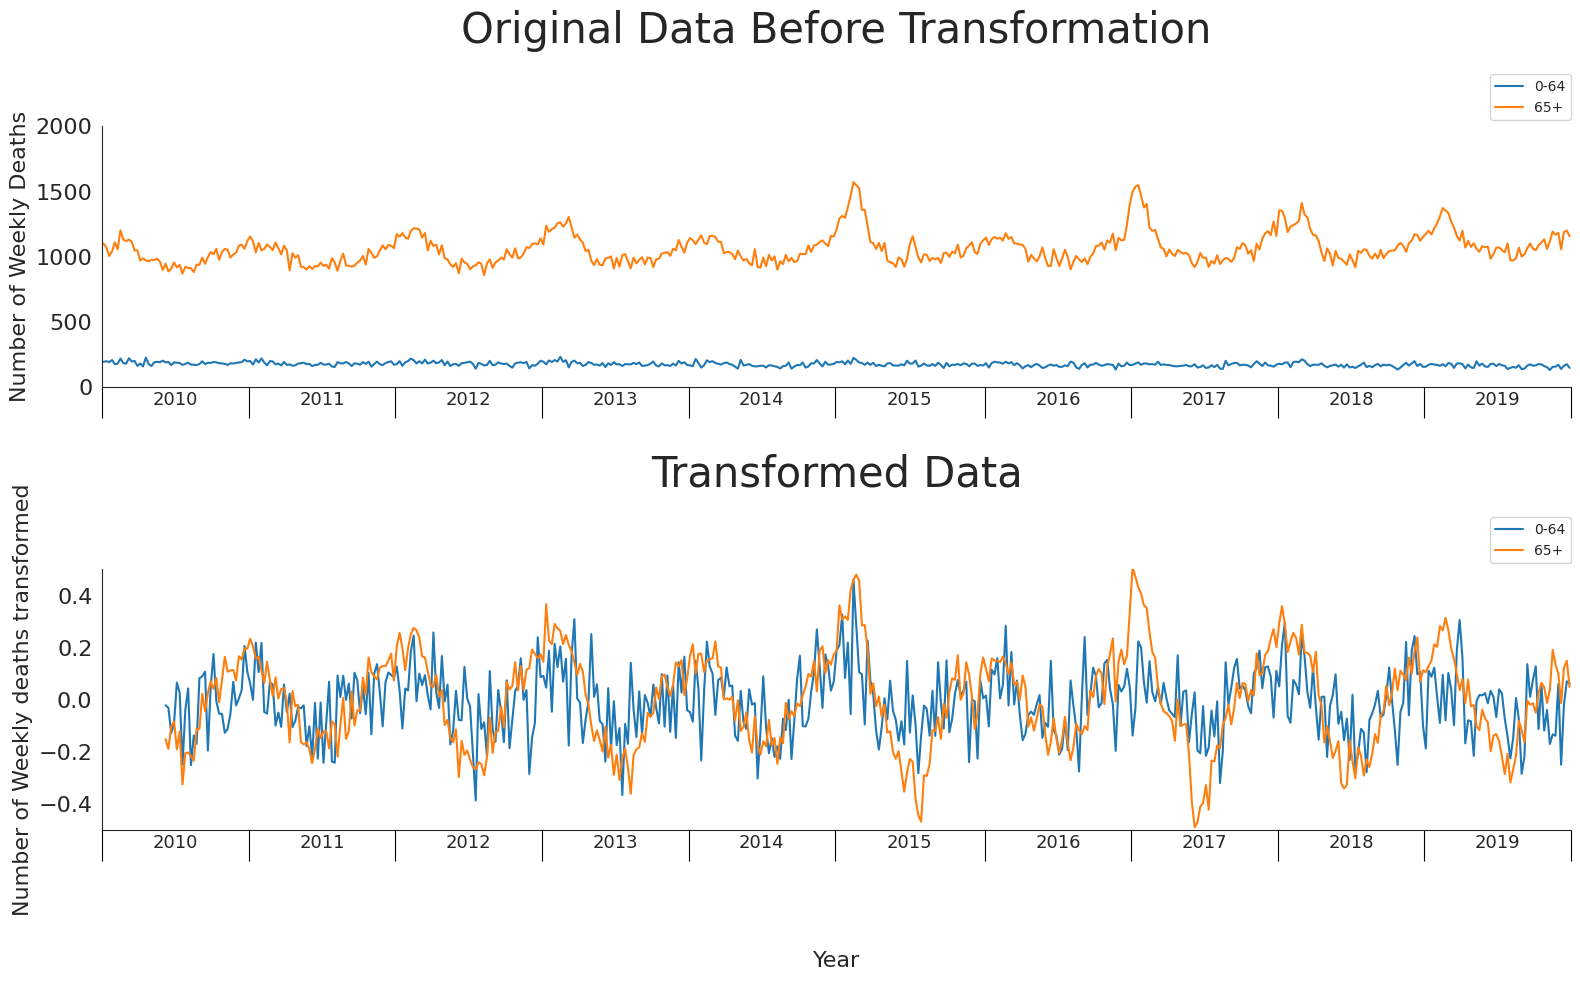

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0] = lineplot_multi_category_ax(ax= ax[0], data = pd.concat([df_0_64_train, df_65_plus_train]),
x_values = 'year_week',
y_values = 'NoDeaths_EP',
title = 'Original Data Before Transformation',
hue='Age',
x_axis_label='',
y_axis_label='Number of Weekly Deaths')
ax[0].set_ylim(0,2000)


ax[1] = lineplot_multi_category_ax(ax=ax[1], data = pd.concat([df_0_64_train, df_65_plus_train]),
x_values = 'year_week',
y_values = 'NoDeaths_EP_transformed',
title = 'Transformed Data',
hue='Age',
x_axis_label='Year',
y_axis_label='Number of Weekly deaths transformed')
ax[1].set_ylim(-0.5,0.5)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()

# 9. Create manually an AM(I)RA model
Next, I construct an ARIMA model through manual procedures. Given that the data has already been preprocessed and transformed to achieve stationarity, the order of differencing, denoted as 'I', can be set to zero.
The determination of the appropriate values for the orders 'p' and 'q' can be accomplished by examining the sample autocorrelation function (ACF) and partial autocorrelation function (PACF). In the following part, I show the ACF and PACF of the transformed data.



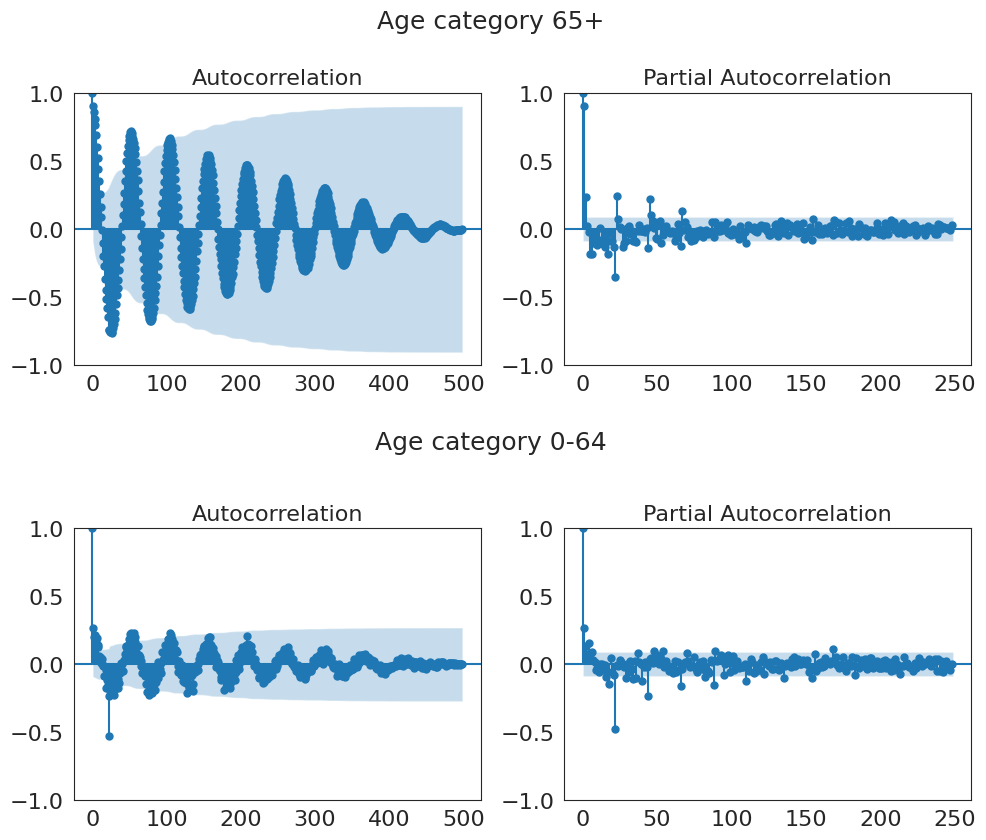

In [9]:
# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot autocorrelation for the age category 65+
plot_acf(df_65_plus_train['NoDeaths_EP_transformed'].dropna(), lags=len(df_65_plus_train['NoDeaths_EP_transformed'].dropna()) - 1, ax=axes[0, 0])
plot_pacf(df_65_plus_train['NoDeaths_EP_transformed'].dropna(), lags=len(df_65_plus_train['NoDeaths_EP_transformed'].dropna()) // 2 - 1, ax=axes[0, 1])

# Plot autocorrelation for the age category 0-64
fig.text(0.5, 0.50, 'Age category 0-64', ha='center', fontsize=18)
plot_acf(df_0_64_train['NoDeaths_EP_transformed'].dropna(), lags=len(df_0_64_train['NoDeaths_EP_transformed'].dropna()) - 1, ax=axes[1, 0])
plot_pacf(df_0_64_train['NoDeaths_EP_transformed'].dropna(), lags=len(df_0_64_train['NoDeaths_EP_transformed'].dropna()) // 2 - 1, ax=axes[1, 1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
fig.suptitle('Age category 65+', fontsize=18, y=1.05)
plt.show()

### How to interpret the autocorrelation and partial autocorrelation data?

1. If the PACF plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually.
This may suggest a ARIMA (p, d, 0) model.

2. If the ACF plot has a significant spike at lag p, but not beyond; the PACF plot decays more gradually.
This may suggest a ARIMA (0, d, q) model

3. Main characteristics of ARMA (p,q) models:

|  | AR(p) | MA(q) |ARMA(p,q)|
| --- | --- | --- | --- |
| **ACF** | Tails off | Cuts of after q |Tails off|
| **PACF** | Cuts off after p | Tails off |Tails off|

&#10132; In this case a ARIMA (p, d, 0) should be an appropriate choice. I will therefore try ARIMA (2, 0, 0) on the transformed data.

## 9.1 Fitting the ARIMA Model
Now, I construct an ARIMA model with the parameters (2,0,0). To maintain clarity and avoid excessive complexity, the subsequent steps will focus solely on the 65+ age category.

In [10]:
models = {}
models['arima_2_0_0'] = {}

# Fit a ARIMA model using on the age category 65+ using manually selected order parameters
models['arima_2_0_0']['model 65+'] = ARIMA(df_65_plus_train['NoDeaths_EP_transformed'].tolist()[diff_period_k1:], order=(2,0,0))
models['arima_2_0_0']['model 65+'] = models['arima_2_0_0']['model 65+'].fit()
models['arima_2_0_0']['model 65+'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 593.900
Date:                Mon, 17 Jul 2023   AIC                          -1179.800
Time:                        16:15:51   BIC                          -1162.950
Sample:                             0   HQIC                         -1173.188
                                - 499                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.044     -0.017      0.987      -0.088       0.086
ar.L1          0.6864      0.044     15.753      0.000       0.601       0.772
ar.L2          0.2409      0.046      5.214      0.000       0.150       0.331
sigma2         0.0054      0.000     15.779      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.93   Prob(JB):                         0.96
Heteroskedasticity (H):               1.23   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For the evaluation of the model, I will also calculate the mean absolute error and the root mean square error:

In [11]:
def add_model_metrics(models:ARIMA, model_name:str, train_data:pd.DataFrame, test_data:pd.DataFrame, val_col_name:str='NoDeaths_EP', auto_arima_model = False):
    #Metrics transformed space
    models[model_name]['metrics'] = {}

    if not auto_arima_model:
        model_pred_train = models[model_name]['model 65+'].fittedvalues
        model_pred_test = models[model_name]['model 65+'].forecast(len(test_data))
    
    
        models[model_name]['metrics']['mae_transf_train'] = mean_absolute_error(
                                            train_data[val_col_name + '_transformed'].to_numpy()[diff_period_k1:], 
                                            model_pred_train)
        models[model_name]['metrics']['rmse_transf_train'] = np.sqrt(
                                                mean_squared_error(
                                                    train_data[val_col_name + '_transformed'].to_numpy()[diff_period_k1:], 
                                                    model_pred_train
                                                                    )
                                                        )
        
        models[model_name]['metrics']['mae_transf_test'] = mean_absolute_error(
                                            test_data[val_col_name + '_transformed'].to_numpy(), 
                                            model_pred_test)
        
        models[model_name]['metrics']['rmse_transf_test'] = np.sqrt(
                                                mean_squared_error(
                                                    test_data[val_col_name + '_transformed'].to_numpy(), 
                                                    model_pred_test
                                                                    )
                                                        )
        #Metrics original space
        
        model_pred_train_orig_space = invert_differencing(
                                                data = pd.Series(model_pred_train).copy(), 
                                                period=diff_period_k1, 
                                                first_values=np.log(train_data[val_col_name].reset_index(drop=True)[diff_period_k1:2*diff_period_k1]).copy()
                                                ).map(lambda x: np.exp(x)
                                                ).tolist()
                                                
        
        model_pred_test_orig_space = invert_differencing(
                                                data = pd.Series(model_pred_test).copy(), 
                                                period=diff_period_k1, 
                                                first_values=np.log(test_data[val_col_name].reset_index(drop=True)[0:diff_period_k1]).copy()
                                                ).map(lambda x: np.exp(x)
                                                ).tolist()
    if auto_arima_model:
        model_pred_train_orig_space = models[model_name]['model 65+'].fittedvalues()[diff_period_k1:]
        model_pred_test_orig_space = models[model_name]['model 65+'].predict(n_periods = len(test_data))

    models[model_name]['metrics']['mae_train'] = mean_absolute_error(
                                          train_data[val_col_name].to_numpy()[diff_period_k1:], 
                                          model_pred_train_orig_space)
    
    models[model_name]['metrics']['rmse_train'] = np.sqrt(
                                               mean_squared_error(
                                                   train_data[val_col_name ].to_numpy()[diff_period_k1:], 
                                                   model_pred_train_orig_space
                                                                 )
                                                    )
    
    models[model_name]['metrics']['mae_test'] = mean_absolute_error(
                                          test_data[val_col_name].to_numpy(), 
                                          model_pred_test_orig_space)
    
    models[model_name]['metrics']['rmse_test'] = np.sqrt(
                                               mean_squared_error(
                                                   test_data[val_col_name].to_numpy(), 
                                                   model_pred_test_orig_space
                                                                 )
                                                    )
    print('Calculated model metrics:')
    print('--------------------------')
    if not auto_arima_model:
        print('mae train set,  transformed space: ', models[model_name]['metrics']['mae_transf_train'])
        print('mae test set,   transformed space: ', models[model_name]['metrics']['mae_transf_test'])
        print('rmse train set, transformed space: ', models[model_name]['metrics']['rmse_transf_train'])
        print('rmse test set,  transformed space: ', models[model_name]['metrics']['rmse_transf_test'])
        print()
    print('mae train set,  original space:', models[model_name]['metrics']['mae_train'])
    print('mae test set,   original space:', models[model_name]['metrics']['mae_test'])
    print('rmse train set, original space:', models[model_name]['metrics']['rmse_train'])
    print('rmse test set,  orignial space:', models[model_name]['metrics']['rmse_test'])


    
add_model_metrics(models, 
                  model_name='arima_2_0_0', 
                  train_data=df_65_plus_train, 
                  test_data=df_65_plus_test, 
                  val_col_name='NoDeaths_EP')

Calculated model metrics:
--------------------------
mae train set,  transformed space:  0.05845368511718552
mae test set,   transformed space:  0.22474964893628527
rmse train set, transformed space:  0.0737212771794442
rmse test set,  transformed space:  0.28612723603616286

mae train set,  original space: 51.09042040591997
mae test set,   original space: 188.2642748115034
rmse train set, original space: 65.83655646927289
rmse test set,  orignial space: 263.2478898947039


The metrics look okay. As expected the values for the test data are slighly worse than the ones for the train data. In the transformed space the values are larger because the data is not centered around zero. 
## 9.3 Evaluate the model fit
### 9.3.1 Analyzing the residuals by visualization


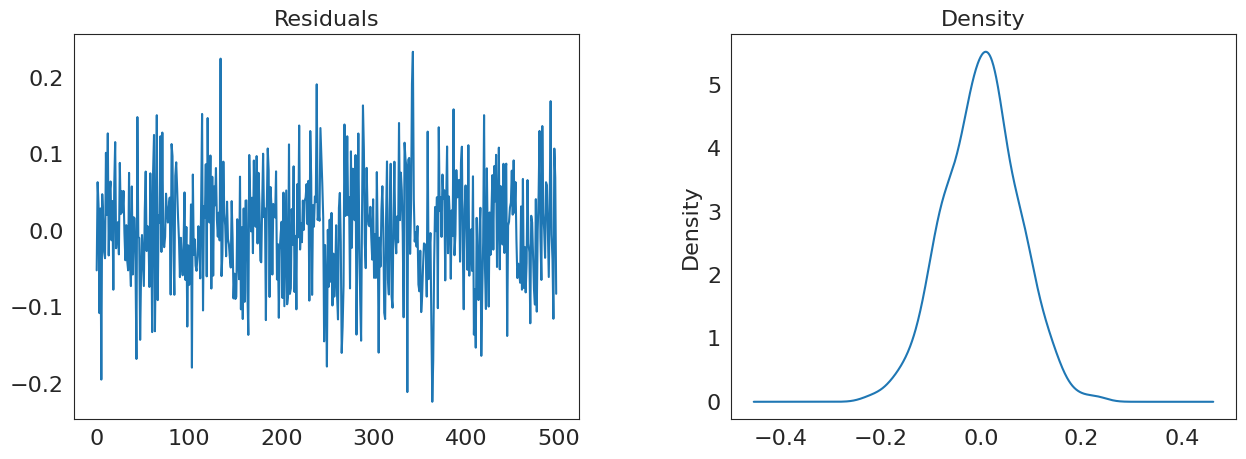

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot residuals for the age category 65+ model
models['arima_2_0_0']['model residuals 65+'] = pd.Series(models['arima_2_0_0']['model 65+'].resid[1:])
models['arima_2_0_0']['model residuals 65+'].plot(title='Residuals', ax=axes[0])
models['arima_2_0_0']['model residuals 65+'].plot(title='Density', kind='kde', ax=axes[1])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  
plt.subplots_adjust(hspace=0.45)  

fig.suptitle('', fontsize=18, y=0.97)
plt.show()

**Interpretation residual plot:** &nbsp;The residuals look like white noise &#10132; this is a good sign <br>
**Interpretation density plot:** &nbsp;&nbsp;The density of the residuals looks normally distributed, with a mean of around zero &#10132; this is a good sign

### 9.3.2. Analyzing the ACF and the PACF of the residuals

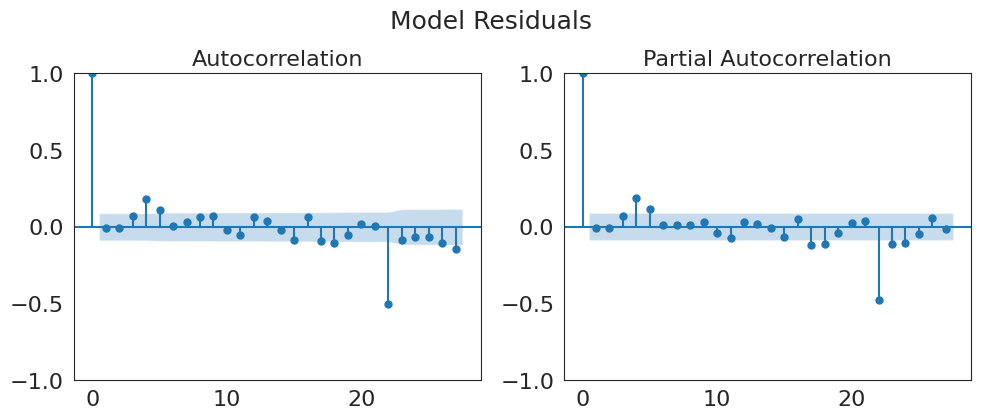

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the autocorrelation and partial autocorrelation of the residuals of the age category 65+ model
acf_res = plot_acf(models['arima_2_0_0']['model residuals 65+'].dropna(), ax=axes[0])
pacf_res = plot_pacf(models['arima_2_0_0']['model residuals 65+'].dropna(), ax=axes[1])

plt.tight_layout()
fig.suptitle('Model Residuals', fontsize=18, y=1.05)
plt.show()

**Intrepretation:**&emsp;&nbsp;Lower lags barely show any significant spikes. This shows that the residuals are close to white noise.

&#10132; We are ready to forcast

## 9.3.3 Plot model fit and forecast
In this part, I plot the fitted and predticted values and compare them to the actual (true) values. This allows for a visual evaluation of the model quality:

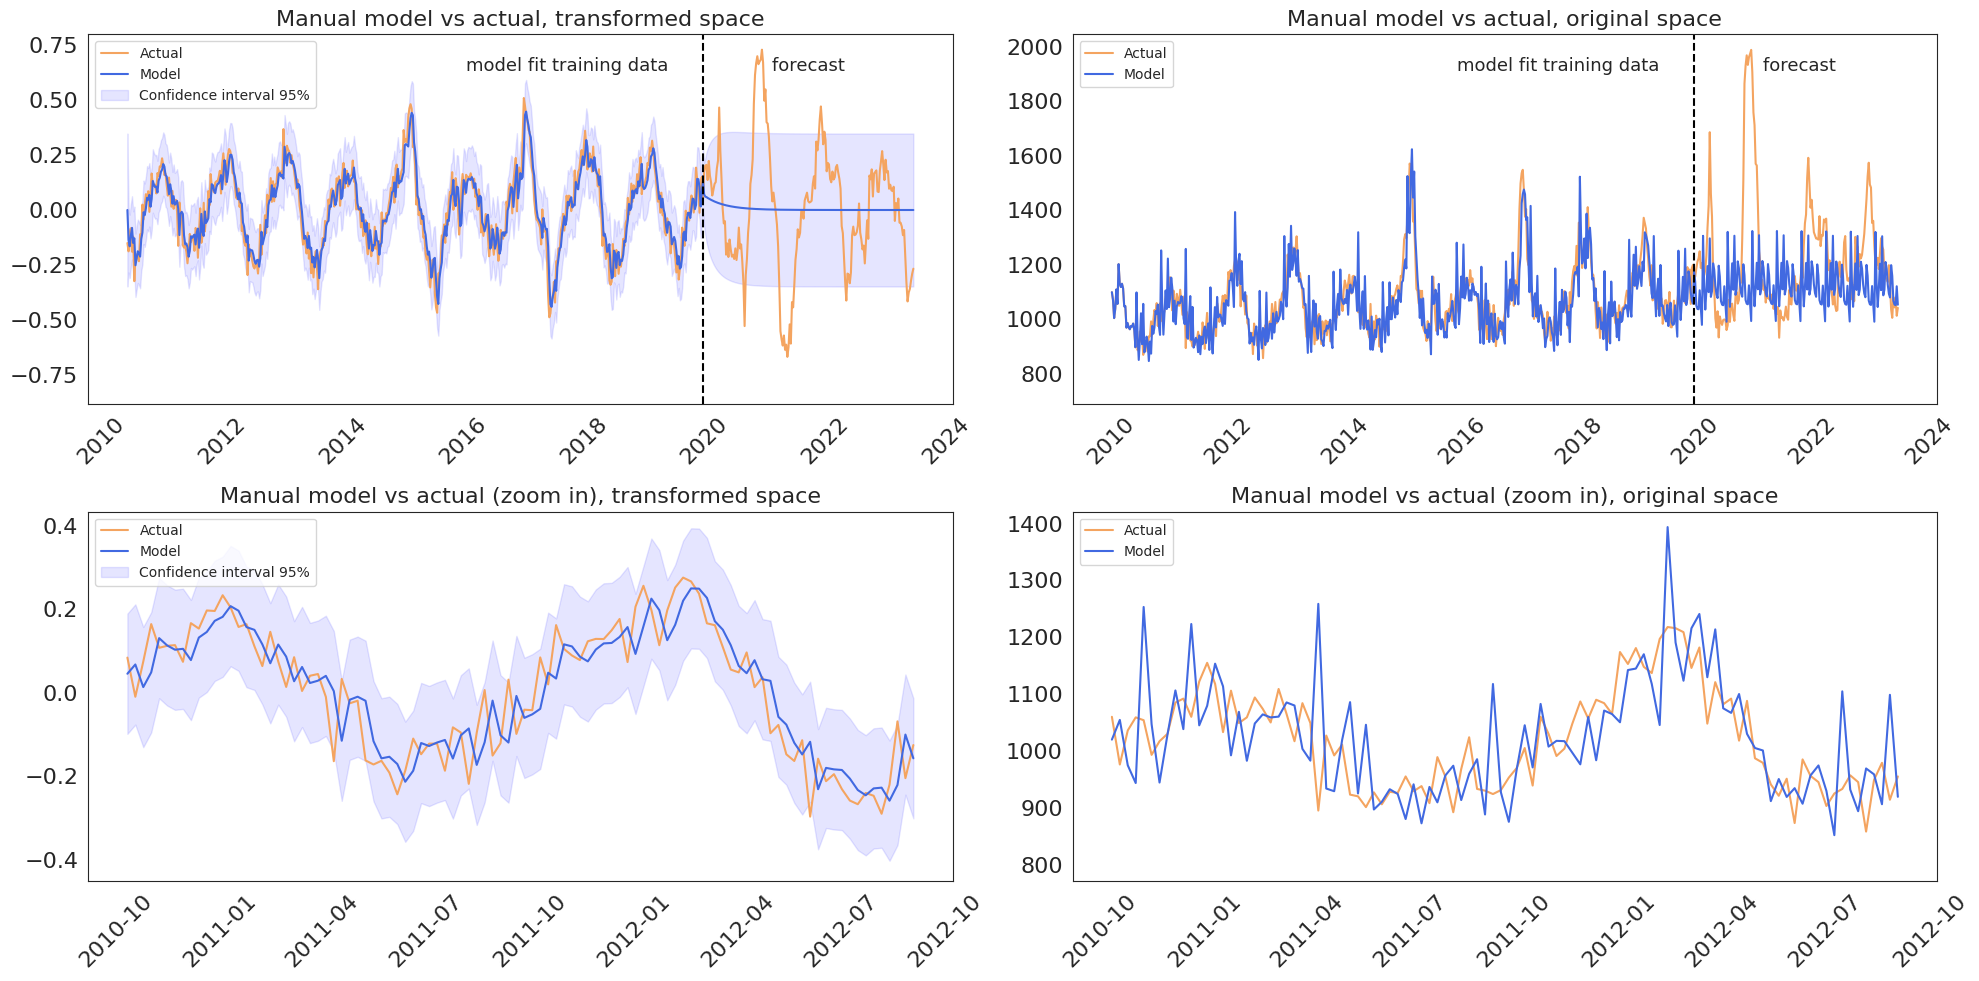

In [14]:
def plot_model_and_series(title:str, ax:plt.Axes, ts_data_train:pd.DataFrame, ts_data_test:pd.DataFrame, y_col:str, model, diff_period_k1:str, slice_lower_upper:tuple=None, back_transform_model:bool=False, auto_arima_model=False):
    y_train = ts_data_train[y_col]
    y_test = ts_data_test[y_col]
    y = pd.concat([y_train, y_test], axis=0)
    x_train = y_train.index.to_numpy()
    x_test = y_test.index.to_numpy()
    x = np.concatenate([x_train, x_test])
    if not auto_arima_model:
        y_fitted = model.fittedvalues
        y_predicted = model.forecast(len(y_test))
    else:
        y_fitted = model.fittedvalues()
        y_predicted = model.predict(n_periods = len(y_test))
    y_model = np.concatenate([y_fitted, y_predicted])
    
    if not auto_arima_model:
        y_model = np.insert(y_model, 0, np.full(diff_period_k1, np.nan))

    confidence_level = 0.95
    alpha = 1 - confidence_level
    
    if not auto_arima_model:
        prediction = model.get_prediction()
        y_train_conf_lower = prediction.conf_int(alpha=alpha)[:, 0]
        y_train_conf_upper = prediction.conf_int(alpha=alpha)[:, 1]

        forecast = model.get_forecast(len(y_test))
        y_test_conf_lower = forecast .conf_int(alpha=alpha)[:, 0]
        y_test_conf_upper = forecast .conf_int(alpha=alpha)[:, 1]

        y_conf_lower = np.concatenate([y_train_conf_lower, y_test_conf_lower])
        y_conf_lower = np.insert(y_conf_lower, 0, np.full(diff_period_k1, np.nan))
        y_conf_upper = np.concatenate([y_train_conf_upper, y_test_conf_upper])
        y_conf_upper = np.insert(y_conf_upper, 0, np.full(diff_period_k1, np.nan))

    if back_transform_model:
        y_model = invert_differencing(
                                            data = pd.Series(y_model).copy(), 
                                            period=diff_period_k1, 
                                            first_values=np.log(y.reset_index(drop=True)[0:diff_period_k1]).copy()
                                            ).map(lambda x: np.exp(x)
                                            ).tolist()
        
    if slice_lower_upper is not None:
        x = x[slice_lower_upper[0]:slice_lower_upper[1]]
        y = y[slice_lower_upper[0]:slice_lower_upper[1]]
        y_model = y_model[slice_lower_upper[0]:slice_lower_upper[1]]
        if not auto_arima_model:
            y_conf_lower = y_conf_lower[slice_lower_upper[0]:slice_lower_upper[1]]
            y_conf_upper = y_conf_upper[slice_lower_upper[0]:slice_lower_upper[1]]

    ax.plot(x, y, label='Actual', color='sandybrown')
    ax.plot(x, y_model, label='Model', color='royalblue')
    if not back_transform_model and not auto_arima_model:
        ax.fill_between(x, y_conf_lower, y_conf_upper, color='b', alpha=.1, label='Confidence interval 95%')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title)
    ax.set_ylim(bottom=(min(y[~np.isnan(y)])) - statistics.stdev(y[~np.isnan(y)]))
    ax.legend(loc='upper left')
    if x_train[-1] < x[-1]:
        ax.vlines(x=x_train[-1], ymin=0, ymax=1, transform= transforms.blended_transform_factory( ax.transData, ax.transAxes), colors = 'black', linestyles = "dashed")
        ax.text(x=x_train[-1], y=0.9, transform= transforms.blended_transform_factory( ax.transData, ax.transAxes), s='model fit training data      ', ha='right')
        ax.text(x=x_train[-1], y=0.9, transform= transforms.blended_transform_factory( ax.transData, ax.transAxes), s='            forecast', ha='left')

# Create the subplot grid
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plot_model_and_series(title = 'Manual model vs actual, transformed space', ax=ax[0, 0], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP_transformed', model=models['arima_2_0_0']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=None, back_transform_model=False)
plot_model_and_series(title='Manual model vs actual (zoom in), transformed space', ax=ax[1, 0], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP_transformed', model=models['arima_2_0_0']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=(40, 140), back_transform_model=False)
plot_model_and_series(title = 'Manual model vs actual, original space', ax=ax[0, 1], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP', model=models['arima_2_0_0']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=None, back_transform_model=True)
plot_model_and_series(title='Manual model vs actual (zoom in), original space', ax=ax[1, 1], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP', model=models['arima_2_0_0']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=(40, 140), back_transform_model=True)
plt.tight_layout()
plt.show()

models['arima_2_0_0']['model+forecast_orig_space'] = {}
models['arima_2_0_0']['model+forecast_orig_space']['x'] = ax[0, 1].lines[1].get_xdata()
models['arima_2_0_0']['model+forecast_orig_space']['y'] = ax[0, 1].lines[1].get_ydata()

The model shows quite a good fit on the training data. However, the quality of the forecast could be better.

# 10. Auto-fit ARIMA model
There are Python packages available that offer automated functionalities for fitting ARIMA models. In this section, I conduct a comparative analysis between the manual approach of pre-processing time series data and manually selecting order parameters, with an automated approach using the pmdarima package from the statsmodel library. The pmdarima package automates the process of selecting the appropriate model parameters. I leverage the integrated part of the ARIMA model to address the seasonal patterns present in the data. By incorporating the integrated component, the model becomes capable of capturing and accounting for the temporal dependencies and trends inherent in the data.

In [15]:
models['auto_arima'] = {}
models['auto_arima']['model 65+'] = pm.auto_arima(df_65_plus_train['NoDeaths_EP'].tolist(), stepwise=True, seasonal=True)
print('The order parmetes of the auto ARIMA model are:', models['auto_arima']['model 65+'].order)
models['auto_arima']['model 65+'].summary()

The order parmetes of the auto ARIMA model are: (1, 1, 0)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  521
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2812.876
Date:                Mon, 17 Jul 2023   AIC                           5629.753
Time:                        16:16:00   BIC                           5638.260
Sample:                             0   HQIC                          5633.085
                                - 521                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2617      0.038     -6.896      0.000      -0.336      -0.187
sigma2      2928.3070    167.028     17.532      0.000    2600.938    3255.676
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.93   Prob(JB):                         0.15
Heteroskedasticity (H):               1.53   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto ARIMA employed first-order differencing (d=1) on the data like my previous manual pre-processing approach. The moving average component was also set to 0, also aligning with my previous methodology.

I will now calculate the metrics of the auto ARIMA model:

In [16]:
add_model_metrics(models, 
                  model_name='auto_arima', 
                  train_data=df_65_plus_train, 
                  test_data=df_65_plus_test, 
                  val_col_name='NoDeaths_EP',
                  auto_arima_model = True)

Calculated model metrics:
--------------------------
mae train set,  original space: 42.890725408489956
mae test set,   original space: 155.38526428844816
rmse train set, original space: 54.26774657574044
rmse test set,  orignial space: 229.6972090972647


The auto ARIMA model shows similar metrics as the manually created one. I now also analyze the residuals for the auto ARIMA model:

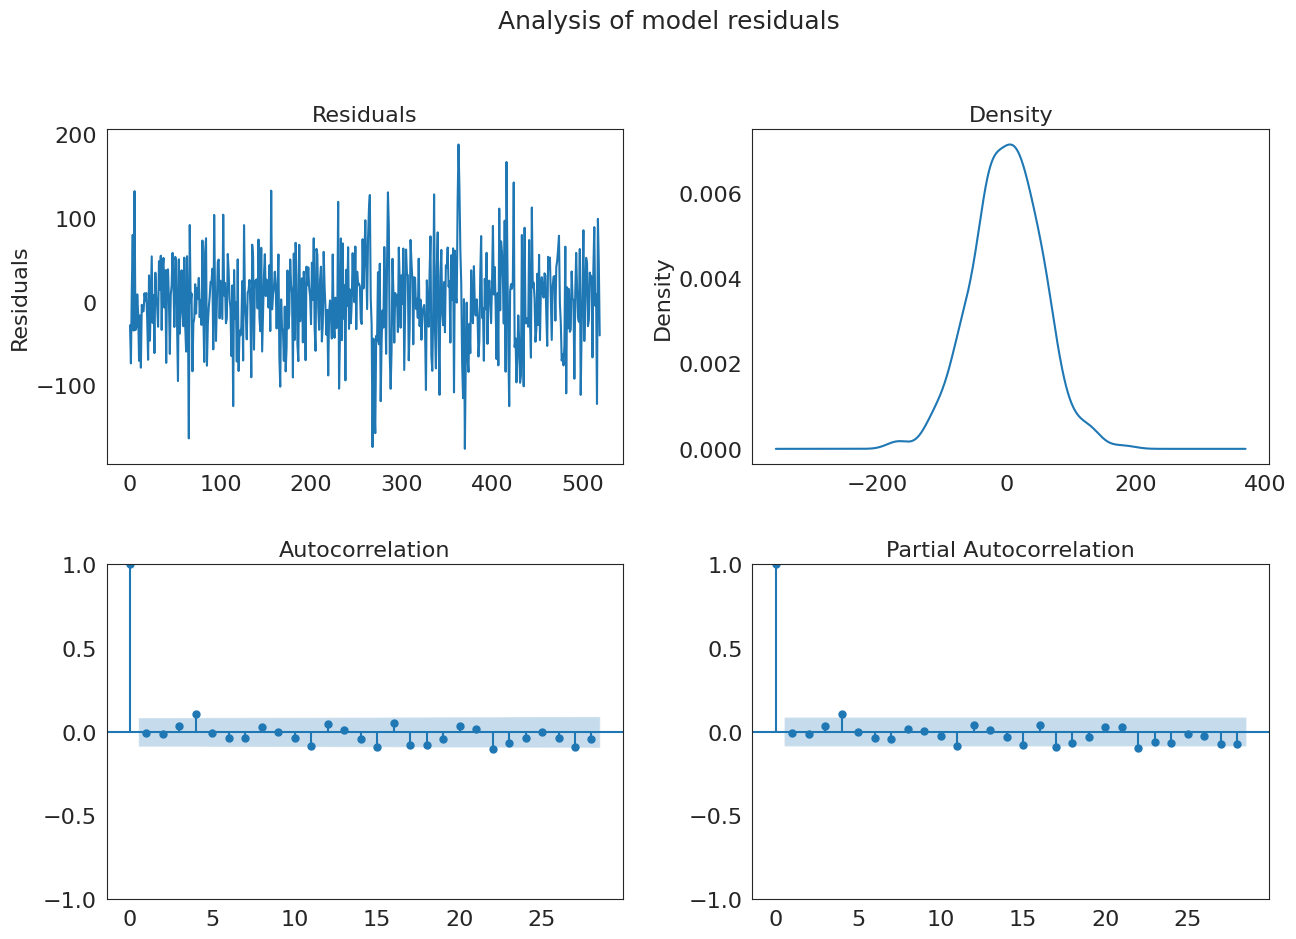

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals for the age category 65+ model
models['auto_arima']['model residuals 65+'] = pd.Series(models['auto_arima']['model 65+'].resid()[1:])
models['auto_arima']['model residuals 65+'].plot(title='Residuals', ax=axes[0,0], ylabel='Residuals')
models['auto_arima']['model residuals 65+'].plot(title='Density', kind='kde', ax=axes[0,1])


acf_res = plot_acf(models['auto_arima']['model residuals 65+'].dropna(), ax=axes[1,0])
pacf_res = plot_pacf(models['auto_arima']['model residuals 65+'].dropna(), ax=axes[1,1])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.25)  
plt.subplots_adjust(hspace=0.3)  

fig.suptitle('Analysis of model residuals', fontsize=18, y=1.0)
plt.show()


**Interpretation residual plot:** &nbsp;The residuals look like white noise &#10132; this is a good sign <br>
**Interpretation density plot:** &nbsp;&nbsp;The density looks normally distributed, with a mean of around zero &#10132; this is a good sign<br>
**Intrepretation of acf/pacf:**&emsp;&nbsp;Lower lags barely show any significant spikes. This shows that the residuals are close to white noise.

&#10132; Similar to the manual model, the auto ARIMA model also exhibits residuals of high quality.


# 11. Compare the models
Finally, I compare the models using the mean absolute error, the root mean square error and a visual evaluation.
<table>
<thead>
  <tr>
    <th></th>
    <th>Manual model</th>
    <th>Auto ARIMA model</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Pre-processing</td>
    <td>logarithm, seasonal differencing</td>
    <td>no pre-processing applied, non-stationarity treated by setting the ARIMA parameter d (integrated part) &gt; 0</td>
  </tr>
  <tr>
    <td>Model space</td>
    <td>transformed space <br>(back transformation needed for using the model predictions in real life)</td>
    <td>original data space</td>
  </tr>
  <tr>
    <td>Model parameters</td>
    <td>2,0,0</td>
    <td>1,1,0</td>
  </tr>
  <tr>
    <td>mean absolute error <br>(original space)</td>
    <td>train/test: 51/188 <br>(after back transformation)</td>
    <td>train/test: 43/155</td>
  </tr>
  <tr>
    <td>root mean square error<br>(original space)</td>
    <td>train/test: 66/263 <br>(after back transformation)</td>
    <td>train/test: 54/230</td>
  </tr>
</tbody>
</table>

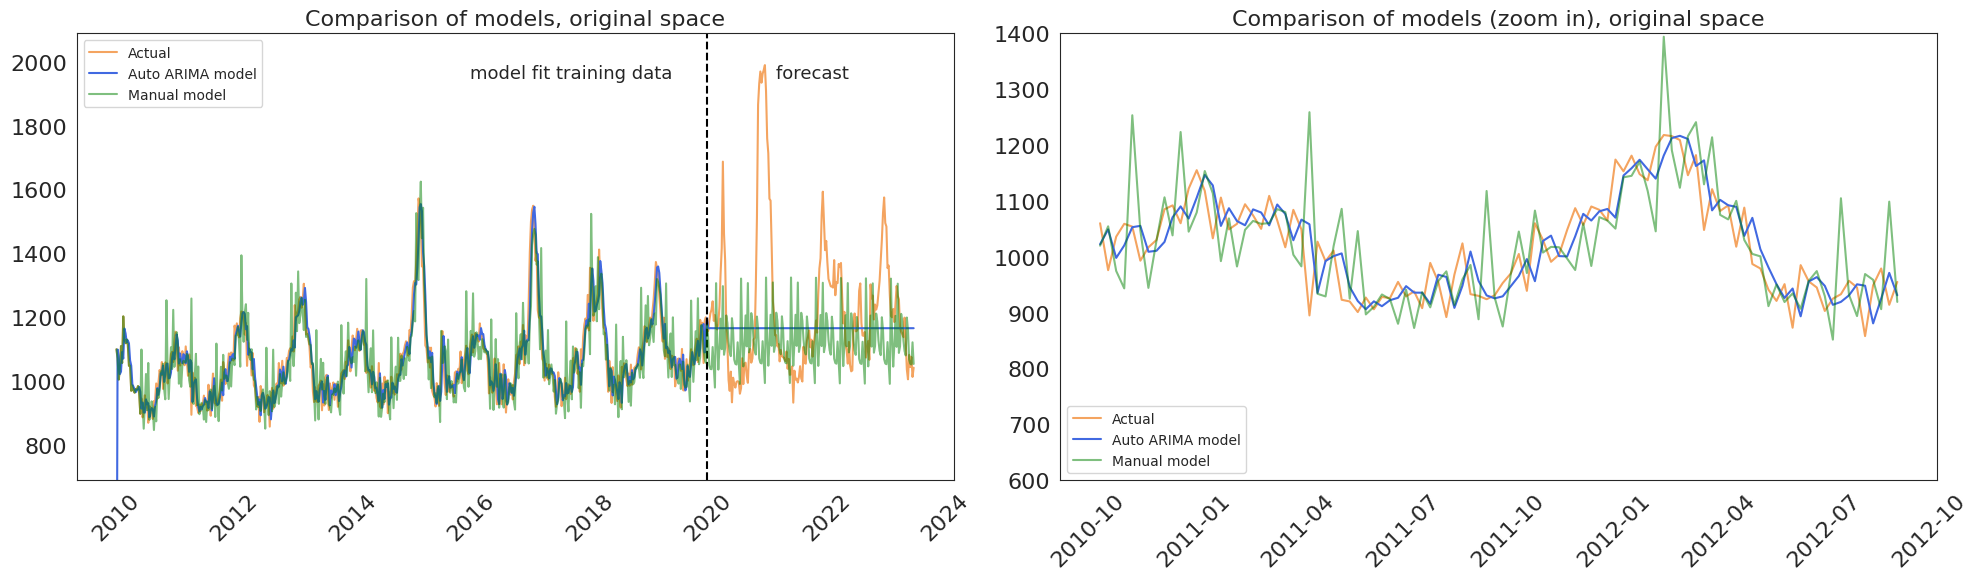

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
plot_model_and_series(title = 'Comparison of models, original space', ax=ax[0], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP', model=models['auto_arima']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=None, back_transform_model=False, auto_arima_model=True)
ax[0].plot(models['arima_2_0_0']['model+forecast_orig_space']['x'], models['arima_2_0_0']['model+forecast_orig_space']['y'], label='Manual model', color='green', alpha=0.5)

plot_model_and_series(title='Comparison of models (zoom in), original space', ax=ax[1], ts_data_train = df_65_plus_train, ts_data_test=df_65_plus_test, y_col = 'NoDeaths_EP', model=models['auto_arima']['model 65+'], diff_period_k1=diff_period_k1, slice_lower_upper=(40, 140), back_transform_model=False, auto_arima_model=True)
ax[1].plot(models['arima_2_0_0']['model+forecast_orig_space']['x'][40:140], models['arima_2_0_0']['model+forecast_orig_space']['y'][40:140], label='Manual model', color='green', alpha=0.5)

warnings.filterwarnings("ignore", message=".*The label '_nolegend_' of .* starts with '_'.*")
ax[0].legend(labels=['Actual', 'Auto ARIMA model', '_nolegend_', 'Manual model'], loc='upper left')
ax[1].legend(labels=['Actual', 'Auto ARIMA model', 'Manual model'], loc='lower left')
ax[1].set_ylim(600, 1400)
plt.tight_layout()
plt.show()

Both, the manually constructed model and the auto ARIMA model have similar order parameters. In both cases, the order of the moving average (MA) component was set to zero, and a first order differencing was applied to the data. However, the manual model demonstrated slightly inferior performance compared to the auto ARIMA model. This difference can be observed visually in the plots, where the manual model exhibits higher fluctuations around the true values. Additionally, the model evaluation metrics, such as mean absolute error (MAE) and root mean square error (RMSE), show lower (better) values for the auto ARIMA model. This values are thus in agreement with the visual interpretation.

One possible explanation for this discrepancy is that the manual model was fitted on pre-processed (transformed) data, while the auto ARIMA model was fitted directly on the original data. Consequently, the data from the manual model needed to be back transformed into the original data space before calculating the evaluation metrics. This transformation process may have introduced additional sources of error, contributing to the slightly worse performance of the manual model.

# 12. Conclusion
The forecast generated by the ARIMA model provides valuable insights into future mortality trends in Switzerland. It can help identify potential seasonal patterns, detect long-term trends, and provide estimates of future death rates. These insights are crucial for policymakers, healthcare professionals, and researchers who are involved in public health planning, resource allocation, and developing interventions to address specific health issues. In this project, I showed two different approaches for generating AMIRA models. Both approaches showed similar results. The training data was nicely fitted on the training set. However, it also truned out that predictions in the far future are not very accurate. The models therefore only give an approximate estimate for the future.
If you have any suggestions for more accurate approaches let me know :) 